# VIIRS Level 2 - Deep Blue Aerosol - AOI Processing, Gridding, and Visualization (Multi-File, AOD Only)

## About

This notebook loads data from multiple VIIRS Level 2 (e.g., AERDB_L2_VIIRS_NOAA20 or AERDB_L2_VIIRS_SNPP) NetCDF files, processes them for a user-defined Area of Interest (AOI), and performs the following:
1. Extracts latitude, longitude, Aerosol Optical Depth at 550nm, and Quality Flags (Land & Ocean).
2. Converts Scan Start Time (TAI93 seconds) to datetime objects.
3. Filters data for the specified AOI and good quality flags (QA=2 'Moderate' or QA=3 'Good' from combined Land/Ocean flags).
4. Visualizes a combined AOD map for the AOI.
5. Saves two ASCII (CSV) files:
    a. All individual good-quality pixel data (AOD, QA) within the AOI.
    b. Gridded mean AOD values within the AOI.

## Step 1: Load Python Libraries

In [1]:
import xarray as xr
import numpy as np
import os
import datetime
import glob

# Libraries for plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

## Step 2: User Settings, AOI Definition, and File Discovery

In [2]:
# --- User Settings --- #
data_dir_viirs = '../data/viirs_aod/' # Adjust if your path is different
viirs_file_pattern = os.path.join(data_dir_viirs, "AERDB_L2_VIIRS_NOAA20*.nc") # Example for NOAA-20 VIIRS
# viirs_file_pattern = os.path.join(data_dir_viirs, "AERDB_L2_VIIRS_SNPP*.nc") # Example for SNPP VIIRS

output_image_dir_viirs = '../output/images/' 
output_ascii_dir_viirs = '../output/ascii/'

# Define your Area of Interest (AOI)
lat_min_aoi = 7.0   
lat_max_aoi = 23.0
lon_min_aoi = 95.0
lon_max_aoi = 110.0

# Define grid resolution for mean AOD calculation (in degrees)
grid_resolution = 0.5 # e.g., 0.5 means 0.5x0.5 degree grid cells

# Variable names (Ensure these match your specific VIIRS product)
# These are at the root level in AERDB_L2 products as per provided metadata
lat_var_name = 'Latitude' 
lon_var_name = 'Longitude' 
aod_var_name = 'Aerosol_Optical_Thickness_550_Land_Ocean' 
qa_land_var_name = 'Aerosol_Optical_Thickness_QA_Flag_Land' 
qa_ocean_var_name = 'Aerosol_Optical_Thickness_QA_Flag_Ocean' 
time_coord_name = 'Scan_Start_Time' # This is a 2D variable in AERDB (TAI93 seconds)
# --- End User Settings --- #

os.makedirs(output_image_dir_viirs, exist_ok=True)
os.makedirs(output_ascii_dir_viirs, exist_ok=True)

viirs_file_list = sorted(glob.glob(viirs_file_pattern))

# Initial base_output_filename_prefix, will be refined after processing files
base_output_filename_prefix = "VIIRS_AOD_Combined"

if not viirs_file_list:
    print(f"No VIIRS NetCDF files found in {data_dir_viirs} matching pattern '{viirs_file_pattern}'.")
else:
    print(f"Found {len(viirs_file_list)} VIIRS files to process:")
    for f_name in viirs_file_list:
        print(f"- {f_name}")

Found 2 VIIRS files to process:
- ../data/viirs_aod/AERDB_L2_VIIRS_NOAA20.A2025141.0554.002.2025141181424.nc
- ../data/viirs_aod/AERDB_L2_VIIRS_NOAA20.A2025141.0736.002.2025141195440.nc


## Step 3: Load Data, Process, Clip to AOI, and Aggregate

In [3]:
# Lists to store data for combined plotting (full granules, filtered and NaNed outside AOI)
latitude_all_granules_plot = []
longitude_all_granules_plot = []
aod_for_plot_all_granules = []

# Lists for the first ASCII file (all valid pixels within AOI)
ascii_pixels_datetime = []
ascii_pixels_lat = []
ascii_pixels_lon = []
ascii_pixels_aod = []
ascii_pixels_qf = []

# Lists for data to be gridded (valid pixels within AOI)
lat_for_gridding_aod = []
lon_for_gridding_aod = []
aod_for_gridding = []

var_attributes = {} # To store attributes from the first file
any_file_processed_successfully = False
epoch_tai93 = datetime.datetime(1993, 1, 1, 0, 0, 0, tzinfo=datetime.timezone.utc)

if viirs_file_list:
    for i_file, file_path in enumerate(viirs_file_list):
        print(f"\n--- Processing file: {os.path.basename(file_path)} ---")
        try:
            with xr.open_dataset(file_path, decode_cf=True, decode_timedelta=False) as ds_single:
                lat_granule_raw = ds_single[lat_var_name].data
                lon_granule_raw = ds_single[lon_var_name].data
                aod_granule_raw = ds_single[aod_var_name].data
                qa_land_granule_raw = ds_single[qa_land_var_name].data
                qa_ocean_granule_raw = ds_single[qa_ocean_var_name].data
                time_data_raw = ds_single[time_coord_name].data 

                if i_file == 0: 
                    var_attributes['AOD_long_name'] = ds_single[aod_var_name].attrs.get('long_name', aod_var_name)
                    var_attributes['AOD_units'] = ds_single[aod_var_name].attrs.get('units', '1')
                    var_attributes['AOD_fill_value'] = ds_single[aod_var_name].attrs.get('_FillValue', np.nan)
                    var_attributes['QA_Land_fill_value'] = ds_single[qa_land_var_name].attrs.get('_FillValue', 0) # Per metadata _FillValue is 0
                    var_attributes['QA_Ocean_fill_value'] = ds_single[qa_ocean_var_name].attrs.get('_FillValue', 0) # Per metadata _FillValue is 0
                    var_attributes['Lat_fill_value'] = ds_single[lat_var_name].attrs.get('_FillValue', np.nan)
                    var_attributes['Lon_fill_value'] = ds_single[lon_var_name].attrs.get('_FillValue', np.nan)

                # Process AOD
                aod_fill = var_attributes['AOD_fill_value']
                aod_processed_granule = np.where(aod_granule_raw == aod_fill if not np.isnan(aod_fill) else np.isnan(aod_granule_raw), np.nan, aod_granule_raw)

                # Process and Combine QA Flags (Robust handling for potential NaNs before cast)
                qa_land_fill = var_attributes['QA_Land_fill_value'] 
                qa_ocean_fill = var_attributes['QA_Ocean_fill_value']
                
                qa_land_temp_float = np.array(qa_land_granule_raw, dtype=float)
                qa_land_temp_float_no_nan = np.where(np.isnan(qa_land_temp_float), -1.0, qa_land_temp_float)
                qa_land_processed = np.where(qa_land_temp_float_no_nan == float(qa_land_fill), -1.0, qa_land_temp_float_no_nan).astype(np.int8)

                qa_ocean_temp_float = np.array(qa_ocean_granule_raw, dtype=float)
                qa_ocean_temp_float_no_nan = np.where(np.isnan(qa_ocean_temp_float), -1.0, qa_ocean_temp_float)
                qa_ocean_processed = np.where(qa_ocean_temp_float_no_nan == float(qa_ocean_fill), -1.0, qa_ocean_temp_float_no_nan).astype(np.int8)
                
                qa_combined_granule = np.full_like(aod_processed_granule, -1, dtype=np.int8)
                qa_combined_granule[qa_land_processed != -1] = qa_land_processed[qa_land_processed != -1]
                ocean_pixels_mask = (qa_combined_granule == -1) & (qa_ocean_processed != -1)
                qa_combined_granule[ocean_pixels_mask] = qa_ocean_processed[ocean_pixels_mask]

                # Process Lat/Lon
                lat_fill = var_attributes['Lat_fill_value']
                lon_fill = var_attributes['Lon_fill_value']
                lat_granule = np.where(lat_granule_raw == lat_fill if not np.isnan(lat_fill) else np.isnan(lat_granule_raw), np.nan, lat_granule_raw)
                lon_granule = np.where(lon_granule_raw == lon_fill if not np.isnan(lon_fill) else np.isnan(lon_granule_raw), np.nan, lon_granule_raw)
                
                aoi_mask = (~np.isnan(lat_granule)) & (~np.isnan(lon_granule)) & \
                             (lat_granule >= lat_min_aoi) & (lat_granule <= lat_max_aoi) & \
                             (lon_granule >= lon_min_aoi) & (lon_granule <= lon_max_aoi)
                good_qa_mask = np.isin(qa_combined_granule, [2, 3])
                final_valid_mask = aoi_mask & good_qa_mask
                
                aod_for_plot_granule = np.where(final_valid_mask, aod_processed_granule, np.nan)
                
                latitude_all_granules_plot.append(lat_granule)
                longitude_all_granules_plot.append(lon_granule)
                aod_for_plot_all_granules.append(aod_for_plot_granule)

                if np.any(final_valid_mask):
                    any_file_processed_successfully = True
                
                if time_data_raw.shape == lat_granule_raw.shape:
                    time_pixel_granule = time_data_raw
                elif time_data_raw.ndim == 1 and len(time_data_raw) == lat_granule_raw.shape[0]:
                    time_pixel_granule = np.repeat(time_data_raw[:, np.newaxis], lat_granule_raw.shape[1], axis=1)
                else:
                    print(f"  Warning: {time_coord_name} shape {time_data_raw.shape} not directly compatible. Assigning NaNs.")
                    time_pixel_granule = np.full_like(lat_granule_raw, np.nan, dtype=float)

                lats_to_save = lat_granule[final_valid_mask]
                lons_to_save = lon_granule[final_valid_mask]
                aod_to_save = aod_processed_granule[final_valid_mask]
                qf_to_save = qa_combined_granule[final_valid_mask]
                time_seconds_to_save = time_pixel_granule[final_valid_mask]
                
                for idx_save in range(len(lats_to_save)):
                    time_val_seconds = time_seconds_to_save[idx_save]
                    dt_obj = None
                    if not np.isnan(time_val_seconds):
                        try:
                            dt_obj = epoch_tai93 + datetime.timedelta(seconds=float(time_val_seconds))
                        except (ValueError, TypeError):
                            dt_obj = None
                    
                    if dt_obj is not None:
                        ascii_pixels_datetime.append(dt_obj)
                        ascii_pixels_lat.append(lats_to_save[idx_save])
                        ascii_pixels_lon.append(lons_to_save[idx_save])
                        ascii_pixels_aod.append(aod_to_save[idx_save])
                        ascii_pixels_qf.append(qf_to_save[idx_save])
                        
                        lat_for_gridding_aod.append(lats_to_save[idx_save])
                        lon_for_gridding_aod.append(lons_to_save[idx_save])
                        aod_for_gridding.append(aod_to_save[idx_save])

                print(f"  Data from {os.path.basename(file_path)} processed and AOI/QA filtered pixels collected.")
        except Exception as e:
            print(f"  Error processing file {file_path}: {e}")
            try:
                with xr.open_dataset(file_path, decode_cf=False) as ds_debug:
                    variables_in_file = list(ds_debug.variables.keys())
                    print(f"    Available variables: {variables_in_file}")
            except Exception as e_debug:
                print(f"    Could not list variables from file {file_path}: {e_debug}")
            continue

    # Determine base_output_filename_prefix for output files
    if not any_file_processed_successfully:
        print("No data was successfully processed from any files.")
        # base_output_filename_prefix remains "VIIRS_AOD_Combined" (no _AOI suffix)
    elif len(viirs_file_list) == 1 :
        base_output_filename_prefix = f"{os.path.splitext(os.path.basename(viirs_file_list[0]))[0]}_AOI"
    elif len(viirs_file_list) > 1:
        base_output_filename_prefix = "VIIRS_AOD_Combined_AOI"
    # If viirs_file_list is empty or other unhandled cases, the initial value "VIIRS_AOD_Combined" is used.
    # Note: If no files processed, plots and ASCII saving will be skipped anyway by 'any_file_processed_successfully' flag.
                
    print("Data loading and initial processing complete.")
else:
    print("File list is empty. Nothing to process.")


--- Processing file: AERDB_L2_VIIRS_NOAA20.A2025141.0554.002.2025141181424.nc ---
  Data from AERDB_L2_VIIRS_NOAA20.A2025141.0554.002.2025141181424.nc processed and AOI/QA filtered pixels collected.

--- Processing file: AERDB_L2_VIIRS_NOAA20.A2025141.0736.002.2025141195440.nc ---
  Data from AERDB_L2_VIIRS_NOAA20.A2025141.0736.002.2025141195440.nc processed and AOI/QA filtered pixels collected.
Data loading and initial processing complete.


## Step 4: Define Map Extent (Based on AOI for Plotting)

In [4]:
map_extent_aoi_plot = None
if any_file_processed_successfully: 
    padding = 2.0 # Degrees to pad the AOI for map display
    map_extent_aoi_plot = [lon_min_aoi - padding, lon_max_aoi + padding, 
                           lat_min_aoi - padding, lat_max_aoi + padding]
    print(f"Map extent for AOI plotting (with padding): {map_extent_aoi_plot}")
else:
    print("Cannot define map extent as no data was loaded.")

Map extent for AOI plotting (with padding): [93.0, 112.0, 5.0, 25.0]


## Step 5: Visualize and Save Combined & Clipped AOD Map
Aerosol Optical Depth is filtered for QA=2 or 3 ('Moderate' or 'Good') and shown for the AOI.

AOI AOD Map saved to: ../output/images/VIIRS_AOD_Combined_AOI_AOD550_QA.png


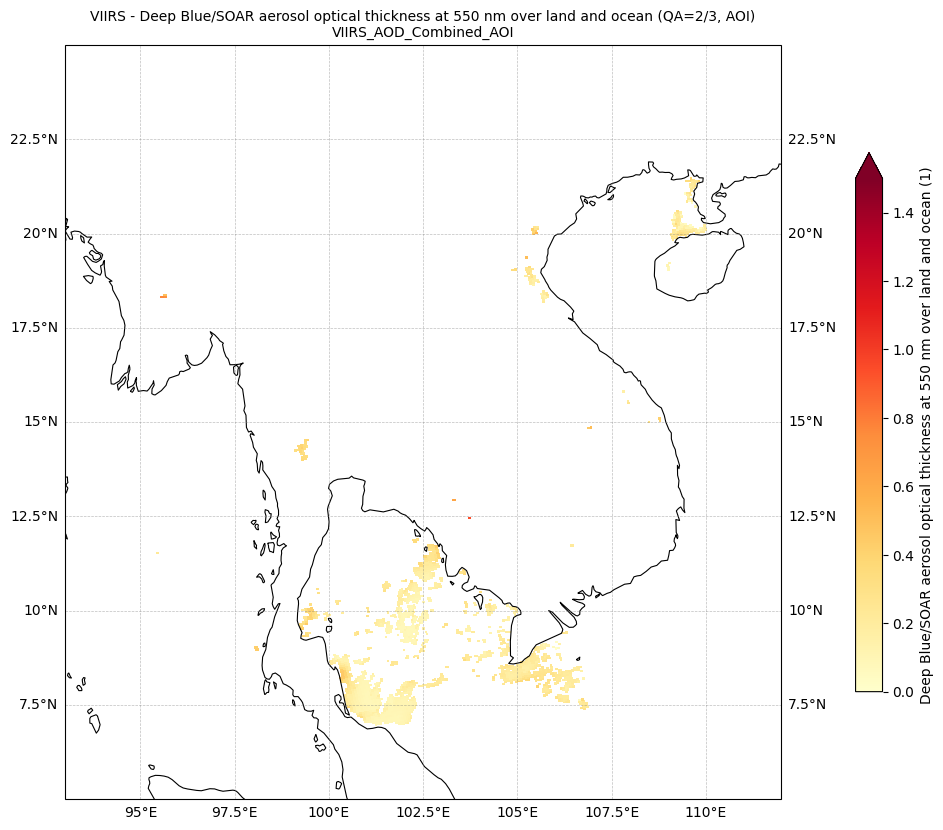

In [5]:
if any_file_processed_successfully and map_extent_aoi_plot is not None and aod_for_plot_all_granules:
    # --- Plot AOD Map ---
    fig_aod = plt.figure(figsize=(12, 10))
    ax_aod = plt.axes(projection=ccrs.PlateCarree())
    try:
        ax_aod.set_extent(map_extent_aoi_plot, crs=ccrs.PlateCarree())
    except Exception as e:
        print(f"Error setting map extent {map_extent_aoi_plot}: {e}. Attempting to use broader extent or global.")
        if longitude_all_granules_plot and latitude_all_granules_plot:
            all_lons_flat = np.concatenate([lon.ravel() for lon in longitude_all_granules_plot if lon.size > 0 and np.any(~np.isnan(lon))])
            all_lats_flat = np.concatenate([lat.ravel() for lat in latitude_all_granules_plot if lat.size > 0 and np.any(~np.isnan(lat))])
            if all_lons_flat.size > 0 and all_lats_flat.size > 0:
                ax_aod.set_extent([np.nanmin(all_lons_flat)-1, np.nanmax(all_lons_flat)+1, np.nanmin(all_lats_flat)-1, np.nanmax(all_lats_flat)+1], crs=ccrs.PlateCarree())
            else:
                ax_aod.set_global()
        else:
             ax_aod.set_global()

    ax_aod.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl_aod = ax_aod.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl_aod.top_labels = False
    gl_aod.right_labels = True 
    gl_aod.xformatter = LONGITUDE_FORMATTER
    gl_aod.yformatter = LATITUDE_FORMATTER
    
    plotted_mesh_aod = None
    for i in range(len(longitude_all_granules_plot)):
        lon_g = longitude_all_granules_plot[i]
        lat_g = latitude_all_granules_plot[i]
        aod_g = aod_for_plot_all_granules[i]
        if aod_g.size > 0 and np.any(~np.isnan(aod_g)):
            mesh = ax_aod.pcolormesh(lon_g, lat_g, aod_g, transform=ccrs.PlateCarree(), cmap='YlOrRd', vmin=0, vmax=1.5, shading='auto')
            if plotted_mesh_aod is None: plotted_mesh_aod = mesh
            
    aod_disp_long_name = var_attributes.get('AOD_long_name', 'AOD at 550nm')
    aod_disp_units = var_attributes.get('AOD_units', '1')
    title_aod = f'VIIRS - {aod_disp_long_name} (QA=2/3, AOI)\n{base_output_filename_prefix}'

    if plotted_mesh_aod:
        cbar_aod = plt.colorbar(plotted_mesh_aod, ax=ax_aod, orientation='vertical', pad=0.08, shrink=0.7, extend='max')
        cbar_aod.set_label(f"{aod_disp_long_name} ({aod_disp_units})")
        plt.title(title_aod, fontsize=10)
    else:
        print("No valid AOD data within AOI to plot across all granules.")
        plt.title(f'{title_aod}\nNo valid data in AOI from loaded files', fontsize=10)
        
    save_fn_aod = f"{base_output_filename_prefix}_AOD550_QA.png" # Adjusted suffix
    full_save_path_aod = os.path.join(output_image_dir_viirs, save_fn_aod)
    plt.savefig(full_save_path_aod, dpi=300, bbox_inches='tight')
    print(f"AOI AOD Map saved to: {full_save_path_aod}")
    plt.show()
    plt.close(fig_aod)
else:
    print("Skipping AOD map plotting: No plottable data or map extent problem.")

## Step 6: Create Gridded Mean AOD for AOI

In [6]:
gridded_mean_aod_for_ascii = [] 

if any_file_processed_successfully and lat_for_gridding_aod and map_extent_aoi_plot is not None:
    print(f"\nCalculating gridded mean AOD for AOI with {grid_resolution}-degree resolution...")
    np_lat_aod_grid = np.array(lat_for_gridding_aod)
    np_lon_aod_grid = np.array(lon_for_gridding_aod)
    np_aod_grid_vals = np.array(aod_for_gridding)
    
    epsilon = 1e-6 
    lon_bins = np.arange(lon_min_aoi, lon_max_aoi + grid_resolution + epsilon, grid_resolution)
    lat_bins = np.arange(lat_min_aoi, lat_max_aoi + grid_resolution + epsilon, grid_resolution)
    
    if len(lon_bins) < 2 or len(lat_bins) < 2:
        print("Warning: Grid resolution too large for AOI, or AOI is too small. Cannot create AOD grid.")
    elif np_lat_aod_grid.size == 0:
        print("No AOD data points available for gridding within AOI and QA criteria.")
    else:
        aod_sum_in_bins, _, _ = np.histogram2d(
            np_lat_aod_grid, 
            np_lon_aod_grid, 
            bins=[lat_bins, lon_bins], 
            weights=np_aod_grid_vals
        )
        points_in_bins, _, _ = np.histogram2d(
            np_lat_aod_grid, 
            np_lon_aod_grid, 
            bins=[lat_bins, lon_bins]
        )
        mean_aod_in_bins = np.full_like(aod_sum_in_bins, np.nan)
        valid_bins_mask = points_in_bins > 0
        mean_aod_in_bins[valid_bins_mask] = aod_sum_in_bins[valid_bins_mask] / points_in_bins[valid_bins_mask]
        
        lon_bin_centers = (lon_bins[:-1] + lon_bins[1:]) / 2
        lat_bin_centers = (lat_bins[:-1] + lat_bins[1:]) / 2
        
        for i_lat, lat_c in enumerate(lat_bin_centers):
            for i_lon, lon_c in enumerate(lon_bin_centers):
                mean_aod_val = mean_aod_in_bins[i_lat, i_lon]
                if not np.isnan(mean_aod_val):
                    gridded_mean_aod_for_ascii.append((lat_c, lon_c, mean_aod_val))
        print(f"Calculated gridded mean AOD for {len(gridded_mean_aod_for_ascii)} grid cells.")
else:
    print("Skipping gridded mean AOD calculation: No data available for gridding or AOI not defined.")


Calculating gridded mean AOD for AOI with 0.5-degree resolution...
Calculated gridded mean AOD for 119 grid cells.


## Step 7: Save Extracted Data to ASCII (CSV) Files

In [7]:
# Save ASCII File 1: All valid pixels within AOI
if any_file_processed_successfully and ascii_pixels_datetime:
    ascii_pixels_filename = f"{base_output_filename_prefix}_pixels.csv" # Adjusted suffix
    full_ascii_pixels_path = os.path.join(output_ascii_dir_viirs, ascii_pixels_filename)
    print(f"\nSaving all valid AOI pixel data to: {full_ascii_pixels_path}")
    with open(full_ascii_pixels_path, 'w') as f:
        f.write("Datetime,Latitude,Longitude,AOD_550_QAfilt,QualityFlag\n") # QAfilt indicates QA=2 or 3
        for i in range(len(ascii_pixels_datetime)):
            dt_obj = ascii_pixels_datetime[i]
            lat_val = ascii_pixels_lat[i]
            lon_val = ascii_pixels_lon[i]
            aod_val = ascii_pixels_aod[i]
            qf_val = ascii_pixels_qf[i]
            dt_str = dt_obj.strftime('%Y-%m-%dT%H:%M:%S.%fZ')
            f.write(f"{dt_str},{lat_val:.4f},{lon_val:.4f},{aod_val:.4f},{int(qf_val)}\n")
        print(f"Finished writing AOI pixel data. {len(ascii_pixels_datetime)} points written.")
else:
    print("Skipping ASCII file for AOI pixels: No valid data points were processed for output.")

# Save ASCII File 2: Gridded mean AOD within AOI
if any_file_processed_successfully and gridded_mean_aod_for_ascii:
    ascii_gridded_aod_filename = f"{base_output_filename_prefix}_gridded_mean_AOD_{grid_resolution}deg.csv" # Adjusted suffix
    full_ascii_gridded_aod_path = os.path.join(output_ascii_dir_viirs, ascii_gridded_aod_filename)
    print(f"\nSaving gridded mean AOD data to: {full_ascii_gridded_aod_path}")
    with open(full_ascii_gridded_aod_path, 'w') as f:
        f.write("Latitude_center,Longitude_center,Mean_AOT550_QAfilt\n") # QAfilt indicates QA=2 or 3
        for lat_c, lon_c, mean_aod in gridded_mean_aod_for_ascii:
            f.write(f"{lat_c:.4f},{lon_c:.4f},{mean_aod:.4f}\n")
        print(f"Finished writing gridded mean AOD. {len(gridded_mean_aod_for_ascii)} grid cells written.")
else:
    print("Skipping ASCII file for gridded mean AOD: No data was available for gridding.")


Saving all valid AOI pixel data to: ../output/ascii/VIIRS_AOD_Combined_AOI_pixels.csv
Finished writing AOI pixel data. 1812 points written.

Saving gridded mean AOD data to: ../output/ascii/VIIRS_AOD_Combined_AOI_gridded_mean_AOD_0.5deg.csv
Finished writing gridded mean AOD. 119 grid cells written.


## End of Processing

In [8]:
print("VIIRS Multi-File AOD Data Processing Complete.")

VIIRS Multi-File AOD Data Processing Complete.
